In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from paths import *
import numpy as np
import pandas as pd

## Load models

In [39]:
sample = "serum"

model_1_name = "GLM_global_compounds_without_outlier_sample_{}.joblib".format(sample)
model_2_name = "GLM_global_compounds_without_outlier_ms_treated_sample_{}.joblib".format(sample)
model_3_name = "GLM_global_compounds_without_outlier_ms_not_treated_sample_{}.joblib".format(sample)
model_4_name = "GLM_global_compounds_with_outlier_sample_{}.joblib".format(sample)
model_5_name = "GLM_global_compounds_with_outlier_ms_treated_sample_{}.joblib".format(sample)
model_6_name = "GLM_global_compounds_with_outlier_ms_not_treated_sample_{}.joblib".format(sample)

model_1 = joblib.load(os.path.join(OUTPUT_PATH, model_1_name))
model_2 = joblib.load(os.path.join(OUTPUT_PATH, model_2_name))
model_3 = joblib.load(os.path.join(OUTPUT_PATH, model_3_name))
model_4 = joblib.load(os.path.join(OUTPUT_PATH, model_4_name))
model_5 = joblib.load(os.path.join(OUTPUT_PATH, model_5_name))
model_6 = joblib.load(os.path.join(OUTPUT_PATH, model_6_name))

model_list = [model_1, model_2, model_3, model_4, model_5, model_6]
model_name_list = ["Without outlier", "Without outlier-MS treated", "Without outlier-MS not treated",
                  "With outlier", "With outlier-MStreated", "With outlier-MS not treated"]

In [40]:
if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
file_path = os.path.join(DATA_ROOT_PATH, filename)
sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]
analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])


## Write model results to an excel sheet

In [20]:
all_model_summary_list = []
for index, model in enumerate(model_list):
    model_summary_list = []
    for item in model:
        chem_id = item["analyte"]
        analyte_name = analyte_metadata[analyte_metadata["CHEM_ID"] == item["analyte"]]["CHEMICAL_NAME"].values[0]
        try:            
            disease_coeff = item["model"].params["Disease_label"]
            disease_coeff_pvalue = item["model"].pvalues["Disease_label"]
            disease_coeff_CI = tuple(item["model"].conf_int().loc['Disease_label'])
            model_converged_flag = item["model"].converged            
        except:
            disease_coeff = None
            disease_coeff_pvalue = None
            disease_coeff_CI = None
            model_converged_flag = None
        model_summary_list.append((analyte_name, chem_id, disease_coeff, disease_coeff_pvalue, disease_coeff_CI, model_converged_flag))        
    all_model_summary_list.append(pd.DataFrame(model_summary_list, columns=["analyte_name", "chem_id", "disease_coeff", "pvalue", "CI", "model_converged_flag"]))

# Create ExcelWriter object
writer = pd.ExcelWriter(os.path.join(OUTPUT_PATH, 'GLM_result_global_compounds_{}_sample.xlsx'.format(sample)))

# Loop through each DataFrame and save to a separate sheet
for i, df in enumerate(all_model_summary_list):
    sheet_name = model_name_list[i]
    df.to_excel(writer, sheet_name=sheet_name, index=False)
    
# Save and close the ExcelWriter object
writer.save()
writer.close()


## Parsing model results for downstream analysis

In [41]:
# Note: Certain analytes have their GLM model as None. 
# This is because those analytes' concentration values were constant across all patient samples.

disease_coeff = []
pval = []
none_model_index = []
pval_thresh = 0.05

for index, model in enumerate(model_list):
    disease_coeff_model = []
    pval_model = []
    for item in model:
        try:
            if (item["model"].pvalues["Disease_label"] < pval_thresh) & (item["model"].converged==1):
                disease_coeff_model.append(item["model"].params["Disease_label"])
                pval_model.append(item["model"].pvalues["Disease_label"])
            else:
                disease_coeff_model.append(None)
                pval_model.append(None)
        except:
            none_model_index.append({"model": item, "model_index":index})                        
            disease_coeff_model.append(None)
            pval_model.append(None)
    disease_coeff.append(disease_coeff_model)
    pval.append(pval_model)
    
analyte_list = []
for item in model_1:    
    analyte_list.append(analyte_metadata[analyte_metadata["CHEM_ID"] == item["analyte"]]["CHEMICAL_NAME"].values[0])
    
disease_coeff = np.array(disease_coeff).transpose()
disease_coeff[disease_coeff == None] = np.nan
disease_coeff = np.where(disease_coeff == None, np.nan, disease_coeff).astype(float)
disease_coeff_df = pd.DataFrame(disease_coeff, index=analyte_list, columns=model_name_list)
# disease_coeff_df = disease_coeff_df.dropna(subset=list(disease_coeff_df.columns))

pval = np.array(pval).transpose()
pval[pval == None] = np.nan
pval = np.where(pval == None, np.nan, pval).astype(float)

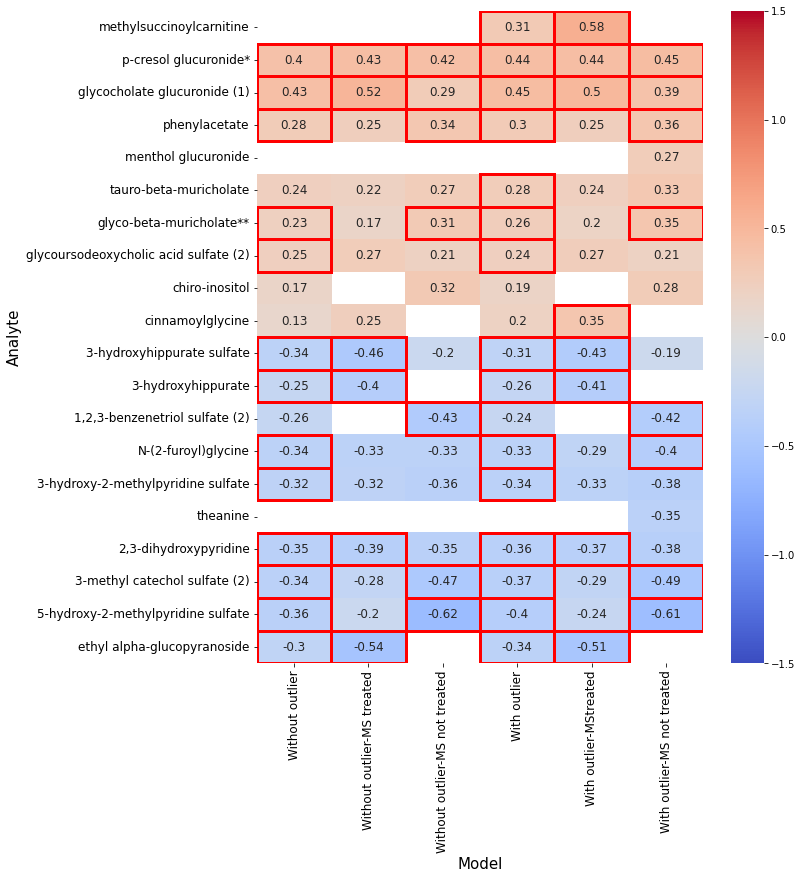

Saving the figure ...


In [42]:
FIG_SIZE = (10, 12)
FONTSIZE = 12
LABELSIZE = 15


avg_coeffs = disease_coeff_df.mean(axis=1, skipna=True)

# Get the top 10 positive and top 10 negative compounds
top_positives = avg_coeffs.nlargest(10).index
top_negatives = avg_coeffs.nsmallest(10).index
top_compounds = pd.concat([avg_coeffs.loc[top_positives], avg_coeffs.loc[top_negatives]]).nlargest(25).index
top_disease_coeff_df = disease_coeff_df.loc[top_compounds]

fig, ax = plt.subplots(figsize=FIG_SIZE)
sns.heatmap(top_disease_coeff_df, cmap='coolwarm', vmin=-1.5, vmax=1.5, annot=True, annot_kws={"fontsize": FONTSIZE})

# Selecting the row indices of top compounds from the original dataframe disease_coeff_df 
red_box_row_index = []
for item in top_disease_coeff_df.index.values:
    red_box_row_index.append(np.where(item == disease_coeff_df.index.values)[0][0])
    
# Select the pval using the selected row indices from above
pval_row_selected = pval[red_box_row_index]
indices = np.where(pval_row_selected < 10**-5)
    
# Add red outline to the boxes
for i, j in zip(indices[0], indices[1]):
    rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
    ax.add_patch(rect)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=FONTSIZE)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=FONTSIZE)
plt.xlabel('Model', fontsize=LABELSIZE)
plt.ylabel('Analyte', fontsize=LABELSIZE)
plt.show()


print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "heat_map_of_disease_coeff_vs_global_iMSMS_compounds_{}_sample_with_red_box_outline.svg".format(sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [104]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Select one of the models
# model_name = model_name_list[0]
# coeff_col = model_name

# # Sort the compounds based on their coefficient value for the selected model
# sorted_df = disease_coeff_df.sort_values(by=coeff_col, ascending=False)
# sorted_df = sorted_df.head(25)

# # Create a horizontal bar chart
# plt.figure(figsize=(8, 6))
# plt.barh(sorted_df.index, sorted_df[coeff_col], color='blue')
# plt.xlabel('Coefficient value')
# plt.ylabel('Analyte')
# plt.title(f'{model_name} - Coefficient values for "disease" predictor')
# # plt.yticks(rotation=45) # Rotate the y-axis labels
# plt.tight_layout() # Adjust the plot layout
# plt.show()



In [105]:


# # Sort the compounds based on their coefficient value for the selected model
# sorted_df = disease_coeff_df.sort_values(by=coeff_col)

# # Create two subplots, one for negative coefficients and one for positive coefficients
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, len(pos_df) / 50]})
# plt.subplots_adjust(wspace=0.5, hspace=0)

# # Plot top 50 compounds with negative coefficients
# neg_df = sorted_df.head(50)
# axes[0].barh(neg_df.index, neg_df[coeff_col], color='red')
# axes[0].set_xlabel('Coefficient value')
# axes[0].set_ylabel('Analyte')
# axes[0].set_title(f'{model_name} - Top 50 compounds with negative coefficients')
# axes[0].tick_params(axis='y', labelsize=8)

# # Plot top 50 compounds with positive coefficients
# pos_df = sorted_df[sorted_df[coeff_col] > 0].tail(50).sort_values(by=coeff_col, ascending=False)
# if len(pos_df) == 1:
#     axes[1].barh(pos_df.index, pos_df[coeff_col], color='green', height=0.2)
# else:
#     axes[1].barh(pos_df.index, pos_df[coeff_col], color='green')
# axes[1].set_xlabel('Coefficient value')
# axes[1].set_ylabel('Analyte')
# axes[1].set_title(f'{model_name} - Top 50 compounds with positive coefficients')
# axes[1].tick_params(axis='y', labelsize=8)

# # Adjust the aspect ratio of the subplots to make the bars narrower
# h, w = fig.get_size_inches()
# fig.set_size_inches(h, w * 0.3 * len(disease_coeff_df) / 50)

# plt.show()
